Note: this includes the code to create the sliding window as well as training TabPFN.



The real training is done in google Colab (for TabPFN, I ended up using XGBoost instead)

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime
from elopy import *
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from elopy import Implementation

### 1. Import & set main dataframe
Import dataset, set df as the original reference dataset

Over/under 74.5 points is -120 odds (for players with about even odds). Need to win at least 54.55% of the time to break even at these odds

In [21]:
df = pd.read_csv("./ttennisData/TTCup.csv")
df = df.fillna(0) # G4+ have 

# ------- Create new columns -------
# Combine P1 and P2 scores for each game
for i in range(1, 6):
    df[f'G{i}_Total'] = df[f'P1_G{i}'] + df[f'P2_G{i}']

# Player 1 total score from G1 to G5
df['Total_P1'] = df[[f'P1_G{i}' for i in range(1, 6)]].sum(axis=1)
df['Total_Avg_P1'] = df['Total_P1']

# Player 2 total score from G1 to G5
df['Total_P2'] = df[[f'P2_G{i}' for i in range(1, 6)]].sum(axis=1)
df['Total_Avg_P2'] = df['Total_P2']

# Sum of combined scores from G1 to G5
df['Total_Score'] = df[[f'G{i}_Total' for i in range(1, 6)]].sum(axis=1)
df['Over_74'] = df['Total_Score'] > 74
df['G5'] = df['G5_Total'] > 0
df['G4'] = (df['G4_Total'] > 0) & (df['G5_Total'] == 0)
df['G45'] = (df['G4_Total'] > 0) | (df['G5_Total'] > 0)
df['G34'] = (df['G5_Total'] == 0)

for i in range(1,6):
    df.rename(columns={f'P1_G{i}': f'G{i}_P1', f'P2_G{i}': f'G{i}_P2'}, inplace=True)

df.rename(columns={'P1_Total': 'Total_P1', 'P2_Total': 'Total_P2'}, inplace=True)

# df['No_Odds'] = (df['Odds_P1'] + df['Odds_P2'] == 0)
# print(df['No_Odds'].sum())

df['Total_Allowed_P1'] = df['Total_P2']
df['Total_Allowed_P2'] = df['Total_P1']

df['Sets_Allowed_P1'] = df['Sets_P2']
df['Sets_Allowed_P2'] = df['Sets_P1']

df['Win_P1'] = df['Total_P1'] > df['Total_P2']
df['Win_P2'] = df['Total_P2'] > df['Total_P1']

# This is just for bill james pythagoren
#df['G34_P1'] = df['G34']
#df['G34_P2'] = df['G34']

df = df.sort_values(by='Date')
df.info()

/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_2191/101049315.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./ttennisData/TTCup.csv")


<class 'pandas.core.frame.DataFrame'>
Index: 117057 entries, 117043 to 117056
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              117057 non-null  float64
 1   Player1           117057 non-null  float64
 2   Player2           117057 non-null  float64
 3   Player1_Name      117057 non-null  object 
 4   Player2_Name      117057 non-null  object 
 5   Sets_P1           117057 non-null  float64
 6   Sets_P2           117057 non-null  float64
 7   Odds_P1           117057 non-null  float64
 8   Odds_P2           117057 non-null  float64
 9   G1_P1             117057 non-null  float64
 10  G1_P2             117057 non-null  float64
 11  G2_P1             117057 non-null  float64
 12  G2_P2             117057 non-null  float64
 13  G3_P1             117057 non-null  float64
 14  G3_P2             117057 non-null  float64
 15  G4_P1             117057 non-null  float64
 16  G4_P2             11

In [22]:
df.head()

,Date,Player1,Player2,Player1_Name,Player2_Name,Sets_P1,Sets_P2,Odds_P1,Odds_P2,G1_P1,G1_P2,G2_P1,G2_P2,G3_P1,G3_P2,G4_P1,G4_P2,G5_P1,G5_P2,HomeWinner,G1_Total,G2_Total,G3_Total,G4_Total,G5_Total,Total_P1,Total_Avg_P1,Total_P2,Total_Avg_P2,Total_Score,Over_74,G5,G4,G45,G34,Total_Allowed_P1,Total_Allowed_P2,Sets_Allowed_P1,Sets_Allowed_P2,Win_P1,Win_P2
117043,1.612281e+09,329135.0,360367.0,0,0,2.0,3.0,1.27,3.35,11.0,9.0,11.0,7.0,6.0,11.0,8.0,11.0,10.0,12.0,0.0,20.0,18.0,17.0,19.0,22.0,46.0,46.0,50.0,50.0,96.0,True,True,False,True,False,50.0,46.0,3.0,2.0,False,True
117042,1.612283e+09,352537.0,328779.0,0,0,1.0,3.0,2.10,1.65,10.0,12.0,6.0,11.0,11.0,4.0,7.0,11.0,0.0,0.0,0.0,22.0,17.0,15.0,18.0,0.0,34.0,34.0,38.0,38.0,72.0,False,False,True,True,True,38.0,34.0,3.0,1.0,False,True
117041,1.612286e+09,329135.0,352537.0,0,0,3.0,0.0,1.60,2.20,11.0,8.0,11.0,4.0,11.0,2.0,0.0,0.0,0.0,0.0,1.0,19.0,15.0,13.0,0.0,0.0,33.0,33.0,14.0,14.0,47.0,False,False,False,False,True,14.0,33.0,0.0,3.0,True,False
117040,1.612288e+09,376223.0,360367.0,0,0,0.0,3.0,1.85,1.85,5.0,11.0,1.0,11.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,16.0,12.0,19.0,0.0,0.0,14.0,14.0,33.0,33.0,47.0,False,False,False,False,True,33.0,14.0,3.0,0.0,False,True
117039,1.612290e+09,329135.0,376223.0,0,0,1.0,3.0,1.35,2.95,11.0,9.0,4.0,11.0,9.0,11.0,8.0,11.0,0.0,0.0,0.0,20.0,15.0,20.0,19.0,0.0,32.0,32.0,42.0,42.0,74.0,False,False,True,True,True,42.0,32.0,3.0,1.0,False,True


### Some rows may contain upcoming data, filter these out
Sept 2026

In [23]:
print(df.shape)
print(f"Number of rows containing upcoming data: {df[df["Total_Score"] == 0].shape}")
df = df[df["Total_Score"] != 0]
print(df.shape)

(117057, 41)
Number of rows containing upcoming data: (13, 41)
(117044, 41)


In [24]:
cont_cols = [
    'Date',
    'Player1',
    'Player2',
    'Sets_P1',
    'Sets_P2',

    'G1_P1',
    'G1_P2',
    'G2_P1',
    'G2_P2',
    'G3_P1',
    'G3_P2',
    'G4_P1',
    'G4_P2',
    'G5_P1',
    'G5_P2',

    'Win_P1',
    'Win_P2',

    #'G34_P1',
    #'G34_P2',
    
#    'No_Odds', # Removed from EDA
    'Total_P1', # Unadjusted total for 74.5.. (careful re: leakage)
    'Total_P2', # Unadjusted total for 74.5.. (careful re: leakage)

    'Total_Avg_P1', # Non-leakage of total
    'Total_Avg_P2', # Non-leakage of total
    'Total_Score', # Unadjusted total (careful re: leakage)
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'Sets_Allowed_P1',
    'Sets_Allowed_P2',
]

track_cols = [
    'Date',
    'Sets',
    'Sets_Allowed',
    'G1',
    'G2',
    'G3',
    'G4',
    'G5',
    
    #'G45',
    #'G34',
    'Win',
    
    'Odds',
    'Total',
    'Total_Avg',
    'Total_Allowed',
]


y_col = ['H_Won']

# Convert columns to int (it originally was int before odds data was added)
for col in cont_cols:
    df[col] = df[col].astype(np.int64)
cont_cols = cont_cols + ['Over_74','G5','G4', 'G34', 'G45', 'Odds_P1','Odds_P2',]

df = df[cont_cols]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 117044 entries, 117043 to 0
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              117044 non-null  int64  
 1   Player1           117044 non-null  int64  
 2   Player2           117044 non-null  int64  
 3   Sets_P1           117044 non-null  int64  
 4   Sets_P2           117044 non-null  int64  
 5   G1_P1             117044 non-null  int64  
 6   G1_P2             117044 non-null  int64  
 7   G2_P1             117044 non-null  int64  
 8   G2_P2             117044 non-null  int64  
 9   G3_P1             117044 non-null  int64  
 10  G3_P2             117044 non-null  int64  
 11  G4_P1             117044 non-null  int64  
 12  G4_P2             117044 non-null  int64  
 13  G5_P1             117044 non-null  int64  
 14  G5_P2             117044 non-null  int64  
 15  Win_P1            117044 non-null  int64  
 16  Win_P2            117044 

# 2. Check and remove missing data
from https://www.kaggle.com/code/gpreda/santander-eda-and-prediction

In [25]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [26]:
pd.set_option('display.max_columns', None)
df.dropna()
missing_data(df)

,Date,Player1,Player2,Sets_P1,Sets_P2,G1_P1,G1_P2,G2_P1,G2_P2,G3_P1,G3_P2,G4_P1,G4_P2,G5_P1,G5_P2,Win_P1,Win_P2,Total_P1,Total_P2,Total_Avg_P1,Total_Avg_P2,Total_Score,Total_Allowed_P1,Total_Allowed_P2,Sets_Allowed_P1,Sets_Allowed_P2,Over_74,G5,G4,G34,G45,Odds_P1,Odds_P2
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bool,bool,bool,bool,bool,float64,float64


### 2. Create a dict to track the track_cols array
create another dict to track previous games for each team during the year

In [27]:
track_dict = {}
elopy = Implementation()

def addToTrackDict(column_name, value):
    """
    Adds value to track_dict. Handles cases where it doesn't exist
    """
    if column_name in track_dict:
        track_dict[column_name].append(value)
    else:
        track_dict[column_name] = [value]
        

for row in df.itertuples():
    year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
    # year = row.Season
    home_team = row.Player1
    visitor_team = row.Player2

    # ELO calculation
    if not elopy.contains(home_team):
        elopy.addPlayer(home_team)
    if not elopy.contains(visitor_team):
        elopy.addPlayer(visitor_team)
    winning_team = home_team if getattr(row, 'Win_P1') == 1 else visitor_team
    elopy.recordMatch(home_team, visitor_team, winner=winning_team)
    addToTrackDict(f'{year}_{home_team}_elo', elopy.getPlayerRating(home_team))
    addToTrackDict(f'{year}_{visitor_team}_elo', elopy.getPlayerRating(visitor_team))
    
    # Home or visitor team has < minimum_window total games
    for col in track_cols:
        if col in ['elo']:
            continue
        home_column_name = f'{year}_{home_team}_{col}'
        visitor_column_name = f'{year}_{visitor_team}_{col}'
        
        # Home team
        home_col = col if col == 'Date' else col + '_P1'
        addToTrackDict(home_column_name, getattr(row, home_col))
        
        # Visitor team
        visitor_col = col if col == 'Date' else col + '_P2'
        addToTrackDict(visitor_column_name, getattr(row, visitor_col))

    
        

## 2a. Calculate the optimal exponent for points/sets pythagorean expectation
From https://copilot.microsoft.com/chats/F2gCDvCuGxG8hWmyky6w1

In [28]:
# track_dict.keys()

### 3. Use track_dict to enforce minimum_window, update df or drop row


In [29]:
print(df.shape)
# df = df[:30000]

(117044, 33)


In [30]:
def get_optimal_exponent(x_for, x_against, win_pct):
    """
    For calculating the optimal exponent in pythagorean expecatation
    
    x_for: np.array up to & not including the current game
    x_against: np.array up to & not including the current game
    win_pct: win pct array
    
    with x being home_pts or score

    Maybe use margin based scaling 
    https://chatgpt.com/c/68f81378-7ddc-8326-907c-10ed768953e3
    
    """
    eps = 1e-6
    # Clip win_pct away from 0/1 to avoid degenerate residuals
    win_pct = np.clip(win_pct, eps, 1 - eps)

    window = 5
    win_pct = np.convolve(win_pct, np.ones(window)/window, mode='valid')
    x_for = x_for[-len(win_pct):]
    x_against = x_against[-len(win_pct):]

    # Ensure strictly positive values before taking logs
    logf = np.log(x_for + eps)
    loga = np.log(x_against + eps)
    
    def pythagorean_expectation(inputs, exponent):
        lf, la = inputs
        z = exponent * (la-lf)
        # clip z to avoid exp overflow; exp(700) ~ 1e304, safe upper bound for float64
        z = np.clip(z, -700, 700)
        return 1.0 / (1.0 + np.exp(z))
        
    params, _ = curve_fit(pythagorean_expectation, (logf, loga), win_pct,
                          p0=1.83, bounds=(0.1,10), maxfev=20000)
    return params[0] # optimal exponent

### get_G34_feature doesn't yield any meaninful results

In [ ]:
minimum_window = 50
ema_span = 50
print(df.shape)

show_examples = False

indices_to_drop = []
current_count = 0

for row in df.itertuples():
    if current_count % 300 == 0:
        print(f'{current_count}/{df.shape[0]}')
    current_count = current_count + 1
    index = row.Index
    year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
    # year = row.Season
    home_team = row.Player1
    visitor_team = row.Player2
    # Home team min window
    home_date_column = f'{year}_{home_team}_Date'
    visitor_date_column = f'{year}_{visitor_team}_Date'

    # Drop indice if not enough data
    if len(track_dict[home_date_column]) <= minimum_window or len(track_dict[visitor_date_column]) <= minimum_window:
        indices_to_drop.append(index)
        continue

    # Current row is older than Home team at min_window
    if row.Date <= track_dict[home_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue
    # Current row is older than Visitor team at min_window
    if row.Date <= track_dict[visitor_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue

    home_date_index = track_dict[home_date_column].index(row.Date)
    visitor_date_index = track_dict[visitor_date_column].index(row.Date)
    # print(f'H: {home_date_index} V: {visitor_date_index}')

    # print("----- Track Cols -----")
    # Update df to have average for each track_cols (Ignoring 'Date', the 1-2nd item)
    for col in track_cols:
        if col in ['Date', 'Odds', 'Total']:
            continue
        else:
            # print(col)
            # Convert to float
            if df.dtypes[col + '_P1'] == 'int64' or df.dtypes[col + '_P2'] == 'int64':
                df = df.astype({f'{col}_P1': 'float64', f'{col}_P2': 'float64'})
            # Update df to have average for each track_cols (Ignoring 'Date', .. items)
            # Update home
            home_col_list = track_dict[f'{year}_{home_team}_{col}'][:home_date_index-1]
            dataframe_val = pd.DataFrame({'value': home_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(home_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, col + '_P1'] = ema

            # Update Visitor
            visitor_col_list = track_dict[f'{year}_{visitor_team}_{col}'][:visitor_date_index-1]
            dataframe_val = pd.DataFrame({'value': visitor_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(visitor_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, col + '_P2'] = ema


    # --------------------------------------------------- 
    # ------------------ Custom Columns -----------------
    # --------------------------------------------------- 
    
    # 1. Add variant of Bill James pythagorean expectation (NFL).
    # 1a. For total points (pythagorean P1, pythagorean P2)
    # Recent games weighted more heavily since 'Final' columns not excluded from the above loop
    home_points_for = np.array(track_dict[f'{year}_{home_team}_Total'][:home_date_index-1])
    home_points_against = np.array(track_dict[f'{year}_{home_team}_Total_Allowed'][:home_date_index-1])
    home_win_pct = track_dict[f'{year}_{home_team}_Win'][:home_date_index-1]
    optimal_exp = get_optimal_exponent(home_points_for, home_points_against, home_win_pct)
    home_points_for = sum(home_points_for)
    home_points_against = sum(home_points_against)
    df.at[index, 'pythagorean_P1'] = home_points_for**optimal_exp / (home_points_for**optimal_exp + home_points_against**optimal_exp)

    visitor_points_for = np.array(track_dict[f'{year}_{visitor_team}_Total'][:visitor_date_index-1])
    visitor_points_against = np.array(track_dict[f'{year}_{visitor_team}_Total_Allowed'][:visitor_date_index-1])
    visitor_win_pct = np.array(track_dict[f'{year}_{visitor_team}_Win'][:visitor_date_index-1])
    optimal_exp = get_optimal_exponent(visitor_points_for, visitor_points_against, visitor_win_pct)
    visitor_points_for = sum(visitor_points_for)
    visitor_points_against = sum(visitor_points_against)
    df.at[index, 'pythagorean_P2'] = visitor_points_for**optimal_exp / (visitor_points_for**optimal_exp + visitor_points_against**optimal_exp)

    # 2. Add ELO for home, away
    df.at[index, 'elo_P1'] = track_dict[f'{year}_{home_team}_elo'][home_date_index-1]
    df.at[index, 'elo_P2'] = track_dict[f'{year}_{visitor_team}_elo'][visitor_date_index-1]
    
"""
    # 1b. For total number of sets (pythagorean_sets_P1, pythagorean_sets_P2)
    home_sets_for = np.array(track_dict[f'{year}_{home_team}_Sets'][:home_date_index-1])
    home_sets_against = np.array(track_dict[f'{year}_{home_team}_Sets_Allowed'][:home_date_index-1])
    home_34_sets = np.array(track_dict[f'{year}_{home_team}_G34'][:home_date_index-1])
    feature, optimal_exp = get_G34_feature(home_sets_for, home_sets_against, home_34_sets)
    home_sets_for = sum(home_sets_for)
    home_sets_against = sum(home_sets_against)
    
    print(f"Optimal exponent: {optimal_exp:.4f}")
    df.at[index, 'pythagorean_sets_P1'] = home_sets_for**optimal_exp / (home_sets_for**optimal_exp + home_sets_against**optimal_exp)

    visitor_sets_for = sum(track_dict[f'{year}_{visitor_team}_Sets'][:visitor_date_index-1])
    visitor_sets_against = sum(track_dict[f'{year}_{visitor_team}_Sets_Allowed'][:visitor_date_index-1])
    df.at[index, 'pythagorean_sets_P2'] = visitor_sets_for**1.83 / (visitor_sets_for**1.83 + visitor_sets_against**1.83)
"""

df.drop(indices_to_drop, inplace=True)

# Add custom metrics to track_cols so it creates the difference (D_) column
# track_cols.append('pythagorean')
for col in track_cols[1:]:
    cont_cols.append('D_' + col)
    df['D_' + col] = (df[col + '_P1'] - df[col + '_P2']).round(3) # Round to 3 sig figs
    
# Remove columns that begin with H_ or V_ in df
# y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
y_col = ['H_start_odds', 'V_start_odds']
df = df.loc[:, ~(df.columns.str.startswith(('H_', 'V_')) & (~df.columns.isin(y_col)))]

print(df.shape)

(117044, 33)
0/117044
300/117044
600/117044
900/117044
1200/117044
1500/117044
1800/117044
2100/117044
2400/117044
2700/117044
3000/117044
3300/117044
3600/117044
3900/117044
4200/117044
4500/117044
4800/117044
5100/117044
5400/117044
5700/117044
6000/117044
6300/117044
6600/117044
6900/117044
7200/117044
7500/117044
7800/117044
8100/117044
8400/117044
8700/117044
9000/117044
9300/117044
9600/117044
9900/117044
10200/117044
10500/117044
10800/117044
11100/117044
11400/117044
11700/117044
12000/117044
12300/117044
12600/117044
12900/117044
13200/117044
13500/117044
13800/117044
14100/117044
14400/117044
14700/117044
15000/117044
15300/117044
15600/117044
15900/117044
16200/117044
16500/117044
16800/117044
17100/117044
17400/117044
17700/117044
18000/117044
18300/117044
18600/117044
18900/117044
19200/117044
19500/117044
19800/117044
20100/117044
20400/117044
20700/117044
21000/117044
21300/117044
21600/117044
21900/117044
22200/117044
22500/117044


In [ ]:
df.head()

In [ ]:
# print(df.info())
df['Over_74'] = df['Over_74'].astype(np.int64)
df['G5'] = df['G5'].astype(np.int64)
df['G4'] = df['G4'].astype(np.int64)
df['G34'] = df['G34'].astype(np.int64)
df['G45'] = df['G45'].astype(np.int64)
print(df.info())

In [ ]:
df.to_csv(f'./ttennisData/TTCupSliding{minimum_window}.csv')

## Continue for Core ML
- Split into train, test, validation
- Training set, if using G5 or G4, will be upsampled or downsampled

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.05, shuffle=False)
X_test, X_validation = train_test_split(X_test, test_size=0.1, shuffle=False)
y_train = X_train['G5']

rus = RandomUnderSampler(random_state=0)
print(f"BEFORE X_train: {X_train.shape}")
# conts_train, y_col = SMOTE().fit_resample(conts_train, y_col)
X_train, y_train = rus.fit_resample(X_train, y_train)
print(f"AFTER conts_train: {X_train.shape}")

# Write to CSV file
X_train.to_csv(f'./ttennisData/CoreMLTrainTTCupSliding{minimum_window}.csv')
X_test.to_csv(f'./ttennisData/CoreMLTestTTCupSliding{minimum_window}.csv')
X_validation.to_csv(f'./ttennisData/CoreMLValidationTTCupSliding{minimum_window}.csv')

# EDA
### ARFS and feature selection

In [16]:
import arfs
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
import arfs.feature_selection.allrelevant as arfsgroot
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)


In [17]:
df = pd.read_csv(f'./ttennisData/TTCupSliding50.csv')
df.info()
df['H_won'] = df['Total_P1'] > df['Total_P2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79574 entries, 0 to 79573
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        79574 non-null  int64  
 1   Date              79574 non-null  int64  
 2   Player1           79574 non-null  int64  
 3   Player2           79574 non-null  int64  
 4   Sets_P1           79574 non-null  float64
 5   Sets_P2           79574 non-null  float64
 6   G1_P1             79574 non-null  float64
 7   G1_P2             79574 non-null  float64
 8   G2_P1             79574 non-null  float64
 9   G2_P2             79574 non-null  float64
 10  G3_P1             79574 non-null  float64
 11  G3_P2             79574 non-null  float64
 12  G4_P1             79574 non-null  float64
 13  G4_P2             79574 non-null  float64
 14  G5_P1             79574 non-null  float64
 15  G5_P2             79574 non-null  float64
 16  Win_P1            79574 non-null  float6

(79574, 23)
(79574,)


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	0
Rejected: 	21
All relevant predictors selected in 00:00:03.27
The selected features: ['Total_Avg_P1' 'Total_Avg_P2']
The agnostic ranking: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2]
The naive ranking: ['Total_Avg_P2', 'Total_Avg_P1', 'Date', 'Sets_P1', 'Sets_P2', 'Player1', 'Player2', 'G1_P2', 'G1_P1', 'G2_P1', 'G2_P2', 'G4_P1', 'G4_P2', 'G3_P1', 'G3_P2', 'G5_P2', 'G5_P1', 'Win_P2', 'Win_P1', 'Total_Allowed_P1', 'Total_Allowed_P2', 'Sets_Allowed_P1', 'Sets_Allowed_P2']


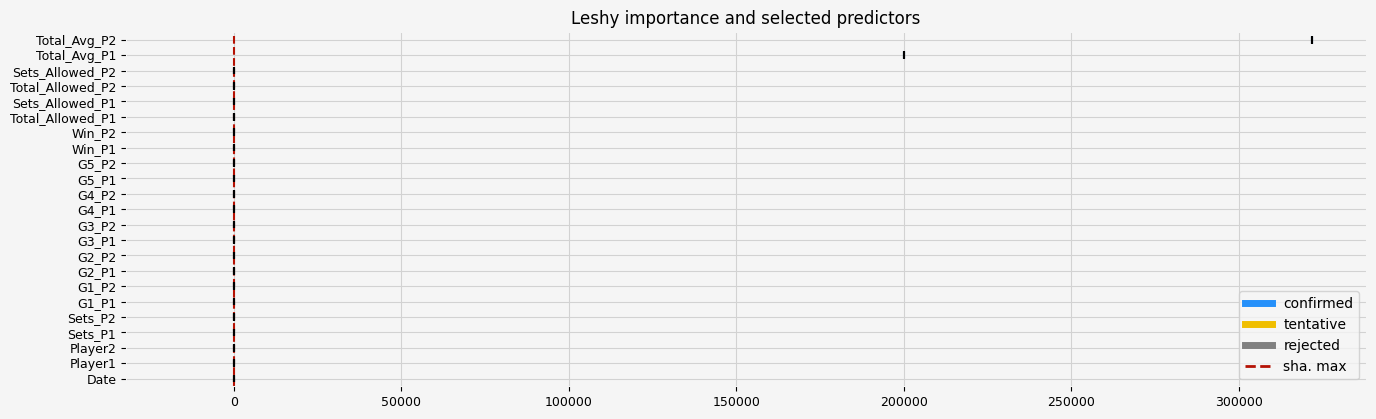

In [19]:
# Load data
x_col = [
    'Date',
    'Player1',
    'Player2',
    'Sets_P1',
    'Sets_P2',

    'G1_P1',
    'G1_P2',
    'G2_P1',
    'G2_P2',
    'G3_P1',
    'G3_P2',
    'G4_P1',
    'G4_P2',
    'G5_P1',
    'G5_P2',

    'Win_P1',
    'Win_P2',

    #'G34_P1',
    #'G34_P2',
    
#    'No_Odds', # Removed from EDA
#    'Total_P1', # Unadjusted total (careful re: leakage)
#    'Total_P2', # Unadjusted total (careful re: leakage)
#    'Total_Score', # Unadjusted total (careful re: leakage)
    'Total_Avg_P1',
    'Total_Avg_P2',
    
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'Sets_Allowed_P1',
    'Sets_Allowed_P2',
]


y_col = ['Over_74']
X = df[x_col]
y = df['Over_74']

print(X.shape)
print(y.shape)

model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [19]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/arfs/feature_selection/allrelevant.py:1556: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/sha

KeyboardInterrupt: 

### TabPfn
This was run in google colab, dont run it on your Mac.. It will crash

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier


slidingDf = pd.read_csv("./ttennisData/TTCupSliding50.csv")

# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    # 'Total_Score',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
y_col = ['G5']
x = slidingDf[x_col]
y = slidingDf[y_col]

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.74, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.85, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(type(y_train))
y_train = y_train.stack().values

# Initialize a classifier
clf = TabPFNClassifier(ignore_pretraining_limits=True)
# (OLD) clf = AutoTabPFNClassifier(ignore_pretraining_limits=True)
clf.fit(X_train, y_train)



(11333, 11)
(11333, 1)
<class 'pandas.core.frame.DataFrame'>


/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/tabpfn/classifier.py:422: UserWarning: Number of samples 11333 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


TabPFNClassifier(ignore_pretraining_limits=True)

In [2]:
X_test_small = X_test[:200]
y_test_small = y_test[:200]
print(X_test_small.shape)
print(y_test_small.shape)
X_test_small.head()

(200, 11)
(200, 1)


,Sets_P1,Sets_P2,Total_P1,Total_P2,Total_Allowed_P1,Total_Allowed_P2,pythagorean_P1,pythagorean_P2,D_Sets,D_Total,D_Total_Allowed
11333,1.832903,2.082338,42,40,39.304441,38.198896,0.507776,0.496560,-0.249,2,1.106
11334,1.801188,2.071721,31,41,36.889583,35.328923,0.487633,0.496992,-0.271,-10,1.561
11335,2.031843,2.011442,47,52,37.421604,40.631598,0.504050,0.508685,0.020,-5,-3.210
11336,2.229349,2.292991,33,22,38.090116,35.919753,0.503506,0.542465,-0.064,11,2.170
11337,1.819615,2.252998,41,48,38.791077,34.828977,0.473162,0.523993,-0.433,-7,3.962


In [ ]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test_small)
print("ROC AUC:", roc_auc_score(y_test_small, prediction_probabilities[:, 1]))

In [ ]:
# Predict labels
predictions = clf.predict(X_test_small)
print("Accuracy", accuracy_score(y_test_small, predictions))